# Use a surrogate model to find the minimum of an expensive cost function

Sometimes our cost function can be expensive to compute, e.g. it may take 10 seconds to compute one value of our cost function and so calling it hundreds or thousands of times in an optimization may take hours.

One way to evaluate the minimum of an expensive cost function is to create a surrogate model.
We can quickly evaluate the surrogate model, so we can call an optimization on the surrogate model to find its minimum.
Then we can evaluate the the expensive cost function at that point and compare.
This can result in a small number of calls to the cost function itself, but still find the minimum.

The key concepts you should gain from this page:

 * How to create a surrogate model of an expensive cost function and use the surrogate model to guide the optimization.

## An interpolated surrogate model

We start by defining a cost function like below.
This should look familar from the previous section.

In [1]:
import numpy
from scipy import stats

def function(p):
    """ Executed for each set of drawn parameters in the optimization search.
    """

    # get the x and y values from Mystic
    x, y = p[0], p[1]

    # get value at Gaussian function x and y
    var = stats.multivariate_normal(mean=[0, 0], cov=[[0.5, 0],[0, 0.5]])
    gauss = -50.0 * var.pdf([x, y])

    # get value at volcano function x and y
    r = numpy.sqrt(x**2 + y**2)
    mu, sigma = 5.0, 1.0
    stat = 10.0 * (numpy.exp(-r / 35.0) + 1.0 /
                   (sigma * numpy.sqrt(2.0 * numpy.pi)) *
                    numpy.exp(-0.5 * ((r - mu) / sigma) ** 2)) + gauss

    # whether to flip sign of function
    # a positive lets you search for minimum
    # a negative lets you search for maximum
    stat *= 1.0

    return stat

Now we are going to use a ``WrapModel``.
We sample for just a few points (e.g. 5) to create an initial surrogate model.
Then use ``InterpModel`` to create the surrogate model.
We are going to create a ``while`` loop that goes until the error between our surrogate model and the optimization search reaches below a threshold.
At each iteration of the ``while`` loop we are going to:

 1. Update our surrogate model.
 2. Find the minimum of the surrogate model.
 3. Compute our cost function at that minimum.
 4. Compare the value of the minimum at the surrogate and the cost function.

In [3]:
from spotlight.bridge.ouq_models import WrapModel
from spotlight.bridge.ouq_models import InterpModel
from mystic.solvers import diffev2
from mystic.monitors import VerboseLoggingMonitor
from mystic.models import AbstractFunction
from scipy import stats
from mystic.models import rosen
from mystic.solvers import BuckshotSolver
from mystic.termination import VTR
from mystic.solvers import NelderMeadSimplexSolver, PowellDirectionalSolver
from pathos.pools import ProcessPool as Pool
from mystic import tools
from mystic.math.legacydata import dataset, datapoint

# set random seed so we can reproduce results
tools.random_seed(0)

# generate a sampled dataset for the model
truth = WrapModel("tmp", function, nx=2, ny=None, cached=False)
bounds = [(-9.5,9.5),(-9.5,9.5)]
data = truth.sample(bounds, pts=5)

# create surrogate model
kwds = dict(smooth=0.0, noise=0.0, method="thin_plate", extrap=False)
surrogate = InterpModel("surrogate", nx=2, ny=None, data=truth, **kwds)

# go until error < 1e-3
error = float("inf")
sign = 1.0
while error > 1e-3:

    # fit surrogate data
    surrogate.fit(data=data)

    # find minimum/maximum of surrogate
    args = dict(bounds=bounds, gtol=500, full_output=True)
    results = diffev2(lambda x: sign * surrogate(x), bounds, npop=20, **args)

    # get minimum/maximum of actual expensive model
    xnew = results[0].tolist()
    ynew = truth(xnew)

    # compute error which is actual model value - surrogate model value
    ysur = results[1]
    error = abs(ynew - ysur)

    # print statements
    print("truth", xnew, ynew)
    print("surrogate", xnew, ysur)
    print("error", ynew - ysur, error)
    print("data", len(data))

    # add latest evaulated point with actual expensive model to be used by surrogate in fitting
    pt = datapoint(xnew, value=ynew)
    data.append(pt)

truth [9.5, -9.499999999999995] 6.812281772380233
surrogate [9.5, -9.499999999999995] -16.239049484486497
error 23.05133125686673 23.05133125686673
data 9
truth [-0.0004929410254516418, 0.0004929455607835783] -5.915670832562705
surrogate [-0.0004929410254516418, 0.0004929455607835783] -5.9154857087032156
error -0.00018512385948987742 0.00018512385948987742
data 10


We can also plot the surface our surrogate model to see what it currently looks like.

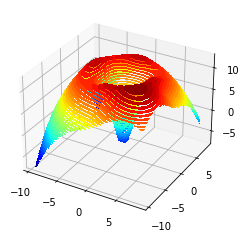

In [4]:
import mystic
# show what our model currently looks like
mystic.model_plotter(lambda x: surrogate(x), depth=True, fill=True, bounds='-9.5:9.5,-9.5:9.5')

## ML surrogate models

Instead of interpolating the surface, we can use a machine learning technique such as an artificial neural network (ANN) or a Gaussian process regressor.
Below, we show an example of using a Gaussian process regressor to accomplish the same analysis.
You can change ``method`` below to switch between the Gaussian process regressor and an ANN.

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from spotlight.bridge.ml import Estimator, MLData, improve_score
from spotlight.bridge.ouq_models import LearnedModel

# set random seed so we can reproduce results
tools.random_seed(0)

# generate a sampled dataset for the model
truth = WrapModel("tmp", function, nx=2, ny=None, cached=False)
bounds = [(-9.5,9.5),(-9.5,9.5)]
data = truth.sample(bounds, pts=5)

# create surrogate model
method = "gp"
if method == "gp":
    kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0))
    regressor = GPRegressor(alpha=1e-10, optimizer=None, n_restarts_optimizer=0, kernel=kernel)
    gpr = Estimator(estimator=regressor, transform=StandardScaler())
    best = improve_score(gpr, MLData(data.coords, data.coords, data.values, data.values), tries=10, verbose=True)
    surrogate = LearnedModel("surrogate", nx=2, ny=None, data=truth, estimator=best.estimator, transform=best.transform)
else:
    regressor = MLPRegressor(hidden_layer_sizes=(100,75,50,25),  max_iter=1000, n_iter_no_change=5, solver='lbfgs', learning_rate_init=0.001)
    mlp = Estimator(estimator=regressor, transform=StandardScaler())
    best = improve_score(mlp, MLData(data.coords, data.coords, data.values, data.values), tries=10, verbose=True)
    surrogate = LearnedModel('surrogate', nx=2, ny=None, data=truth, estimator=best.estimator, transform=best.transform)
    
# go until error < 1e-3
error = float("inf")
sign = 1.0
while error > 1e-3:

    # fit surrogate data
    surrogate.fit(data=data)

    # find minimum/maximum of surrogate
    args = dict(bounds=bounds, gtol=500, full_output=True)
    results = diffev2(lambda x: sign * surrogate(x), bounds, npop=20, **args)

    # get minimum/maximum of actual expensive model
    xnew = results[0].tolist()
    ynew = truth(xnew)

    # compute error which is actual model value - surrogate model value
    ysur = results[1]
    error = abs(ynew - ysur)

    # print statements
    print("truth", xnew, ynew)
    print("surrogate", xnew, ysur)
    print("error", ynew - ysur, error)
    print("data", len(data))

    # add latest evaulated point with actual expensive model to be used by surrogate in fitting
    pt = datapoint(xnew, value=ynew)
    data.append(pt)

score = 1.0
score = 1.0
score = 1.0
score = 1.0
score = 1.0
score = 1.0
score = 1.0
score = 1.0
score = 1.0
score = 1.0
score = 1.0
score = 1.0
score = 1.0
reached max tries
no improvement
truth [6.197898177873798e-08, 2.019894758810447e-08] -5.915479460614437
surrogate [6.197898177873798e-08, 2.019894758810447e-08] -5.915479384931473
error -7.568296389592888e-08 7.568296389592888e-08
data 5


You should now have an understand how to implement an optimization search if the cost function is expensive to compute. We will now move on to how the topics we have covered on the prior pages can be implemented in a Rietveld analysis using MILK.

This tutorial is not meant as a comphrehensive tutorial on Mystic.
For more Mystic documentation and examples, you can check out the [Mystic Documentation](https://mystic.readthedocs.io/en/latest/).